# Model Predictions

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from typing import Tuple
import pickle
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st
from sklearn.model_selection import train_test_split
from loss import PHMAP, phmap_loss

## Pipeline Models

In [2]:
with open('model/trained/xgb_pipe_estimator.pkl', 'rb') as f:
    rul_estimator = pickle.load(f)

with open('model/trained/xgb_pipe_lower.pkl', 'rb') as f:
    lower_bound = pickle.load(f)

with open('model/trained/xgb_pipe_upper.pkl', 'rb') as f:
    upper_bound = pickle.load(f)


## Data

In [3]:
X = pd.read_csv('data/phmap_dataset.csv').drop(
            labels=['unit_names', 'hs'],
            axis=1)
y = pd.read_csv('data/ruls.csv').values.reshape(1, -1)[0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## Model Residuals

In [4]:
residuals = y - rul_estimator.predict(X)

/home/mona/college/pdm/.venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [20:52:14] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


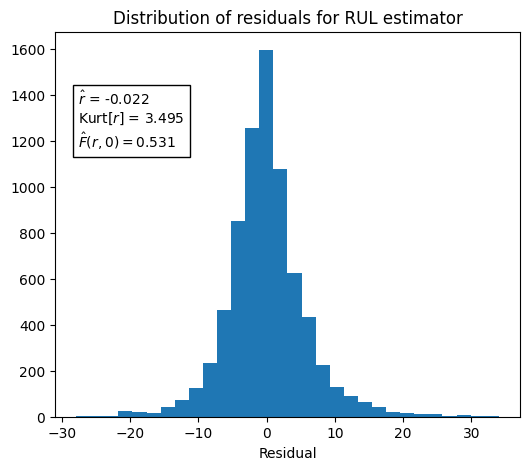

In [5]:
annotations = f"""$\hat{{r}}$ = {np.mean(residuals):.3f}
Kurt$[{{r}}]$ = {st.kurtosis(residuals):.3f}
$\hat{{F}}({{r}}, 0) = {ECDF(residuals)(0):.3f}$"""

fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(residuals,
         bins=30,)
ax.set_title('Distribution of residuals for RUL estimator')
ax.set_xlabel('Residual')
ax.text(x=0.05,
        y=0.7,
        s=annotations,
        transform=ax.transAxes,
        bbox=dict(facecolor='white'))
plt.savefig('img/optimized_xgb_residuals.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

I propose using the RMSE of the model to signal a maintenance warning

In [6]:
thresh = mean_squared_error(y_test, rul_estimator.predict(X_test), squared=False)
thresh

9.83074206690494

In [7]:
X = pd.read_csv('data/phmap_dataset.csv')
y = pd.read_csv('data/ruls.csv').values.reshape(1, -1)[0]
units = X['unit_names'].unique()
X['rul'] = y
for unit in units:
    data = X[X['unit_names'] == unit]
    x = data.drop(['unit_names', 'hs', 'rul'], axis=1)
    y_unit = data['rul']
    rul_estimate = rul_estimator.predict(x)
    lower_rul = lower_bound.predict(x)
    upper_rul = upper_bound.predict(x)
    t = np.arange(0, len(data))
    plt.plot(t, y_unit, label='RUL')
    plt.plot(t, rul_estimate, label='Estimate')
    plt.plot(t, lower_rul, label='Lower Bound (0.1)', linestyle='--')
    plt.plot(t, upper_rul, label='Upper Bound (0.9)', linestyle='--')
    plt.axvline(np.argmax(rul_estimate < thresh),
                label='Maintenance Warning',
                linestyle='dotted')
    plt.fill_between(t, lower_rul, upper_rul, alpha=0.1)
    plt.xlabel('Cycles')
    plt.ylabel('RUL')
    plt.grid()
    plt.suptitle(f'RUL Estimates and 90% PI for {unit}')
    plt.title(f'PHMAP Loss: {phmap_loss(y_unit, rul_estimate):.4f}')
    plt.legend()
    plt.savefig(f'img/xgb/preds_{unit}.png',
                dpi=300,
                bbox_inches='tight')
    plt.close()